In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
from tabulate import tabulate

sys.path.append(os.path.abspath('../..'))
from models import LogisticRegression, LogisticRegressionUndersampling, LogisticRegressionOversampling, LogisticRegressionSmote, LogisticRegressionCostReWeighting
from metrics import ClassificationMetrics
from data_splitting import train_val_split, cross_val
df = pd.read_csv('/home/facuvulcano/Machine-Learning/Vulcano_Facundo_TP3/Problema_1/data/raw/breast_cancer_dev.csv')
df_test = pd.read_csv('/home/facuvulcano/Machine-Learning/Vulcano_Facundo_TP3/Problema_1/data/raw/breast_cancer_test.csv')

In [2]:
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

## **Regresion logistica con regularizacion L2 sin utilizar ningun metodo de balanceo para equilibrar el dataset. Se utiliza cross-validation para entrenar el modelo y la metrica f-score para hallar el hiperparametro de lambda que maximiza su resultado.**

----------------RESULTADOS DE F-SCORE PARA DISTINTOS LAMBDAS----------------

╒══════════╤═══════════╕
│   Lambda │   F-Score │
╞══════════╪═══════════╡
│   0      │  0.644781 │
├──────────┼───────────┤
│   0.0001 │  0.646385 │
├──────────┼───────────┤
│   0.001  │  0.652267 │
├──────────┼───────────┤
│   0.01   │  0.642905 │
├──────────┼───────────┤
│   0.1    │  0.63978  │
├──────────┼───────────┤
│   1      │  0.646176 │
├──────────┼───────────┤
│  10      │  0.337128 │
├──────────┼───────────┤
│ 100      │  0        │
╘══════════╧═══════════╛
El mejor lambda es 0.001 con un f-score promedio de 0.6523


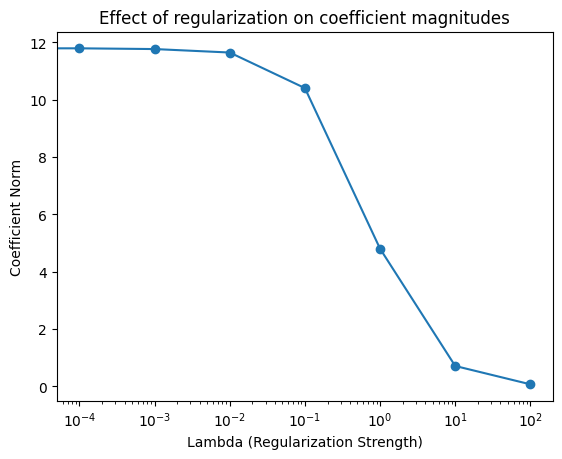

In [3]:
MAX_ITER = 10
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_without_balancing = LogisticRegression(
            threshold=0.245, max_iter=1000, learning_rate=1, lambda_penalty=lambda_
            )
        
        #data splitting
        training, validation = cross_val(df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_without_balancing.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_without_balancing.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_without_balancing.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f_score = metrics.f_score()
            fold_f_scores.append(f_score)

            coef_norm = np.linalg.norm(reg_without_balancing.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'----------------RESULTADOS DE F-SCORE PARA DISTINTOS LAMBDAS----------------\n')
data = {
    'Lambda' : [key for key, _ in global_results.items()],
    'F-Score' : [value for _, value in global_results.items()]
}
data_df = pd.DataFrame(data)
print(tabulate(data_df, headers='keys', tablefmt='fancy_grid', showindex=False))

best_lambda_without_balancing = max(global_results, key=global_results.get)
print(f'El mejor lambda es {best_lambda_without_balancing} con un f-score promedio de {global_results[best_lambda_without_balancing]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

## **Entrenamiento del modelo de regresion logistica sin rebalanceo utilizando todo el dev set completo** (PREGUNTAR)

In [4]:
reg_without_balancing_best_lambda = LogisticRegression(
    threshold=0.245, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_without_balancing
)
print(best_lambda_without_balancing)

X_train_full, y_train_full = df.drop(columns=['target']), df['target']
reg_without_balancing_best_lambda.fit(X_train_full, y_train_full)

0.01


## **Analisis del modelo utilizando diferentes metricas en el test set.**

In [5]:
y_pred_test =  reg_without_balancing_best_lambda.predict(X_test)
y_pred_prob_test = reg_without_balancing_best_lambda.predict_proba(X_test)
metrics_logistic_regr = ClassificationMetrics(y_test, y_pred_test, y_pred_prob_test)

### **1- Matriz de confusion**

In [20]:
metrics_logistic_regr.confusion_matrix()

,Predicted Negative,Predicted Positive
Actual Negative,51,4
Actual Positive,6,8


### **2- Accuracy**

In [6]:
accuracy_lr = metrics_logistic_regr.accuracy()
print(f'The logistic regression model without rebalancing has an accuracy of {accuracy_lr} on the test set')

TP = 8, TN = 51, FP = 4, FN = 6
The logistic regression model without rebalancing has an accuracy of 0.855072463768116 on the test set


### **3- Precision**

In [7]:
precision_lr = metrics_logistic_regr.precision()
print(f'The logistic regression model without rebalancing has a precision of {precision_lr:.5f} on the test set')

The logistic regression model without rebalancing has a precision of 0.66667 on the test set


### **4- F-Score**

In [8]:
f_score_lr = metrics_logistic_regr.f_score()
print(f'The logistic regression model without rebalancing has a f-score of {f_score_lr:.5f} on the test set')

The logistic regression model without rebalancing has a f-score of 0.61538 on the test set


### **5- AUC-PR**

In [9]:
recall_values_lr, precision_values_lr, auc_pr_value_lr = metrics_logistic_regr.auc_pr()
print(f'Precision value for logistic regression model without rebalancing = {auc_pr_value_lr}')

Precision value for logistic regression model without rebalancing = 0.5125742483729394


### **6- Curva PR**

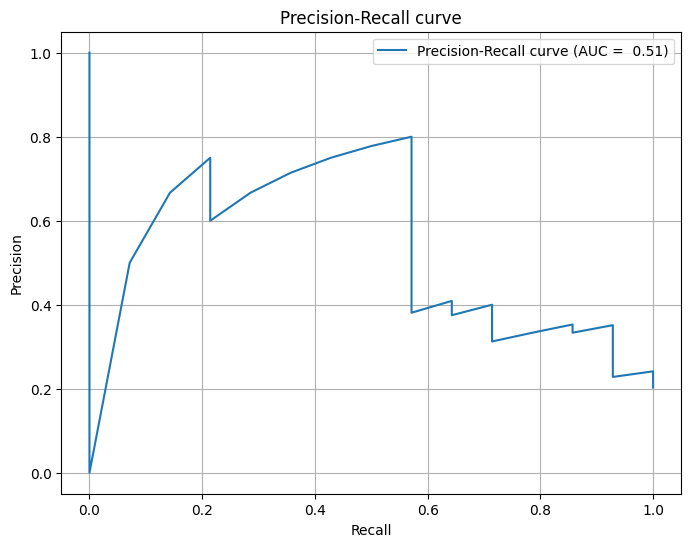

In [10]:
metrics_logistic_regr.plot_pr_curve(recall_values_lr, precision_values_lr, auc_pr_value_lr)

### **7- AUC-ROC**

In [11]:
true_positive_rate_values, false_positive_rate_values, auc_roc_value = metrics_logistic_regr.auc_roc()
print(f'AUC-ROC value for the logistic regression without rebalancing: {auc_roc_value}')

AUC-ROC value for the logistic regression without rebalancing: 0.8012987012987012


### **8- AUC-PR**

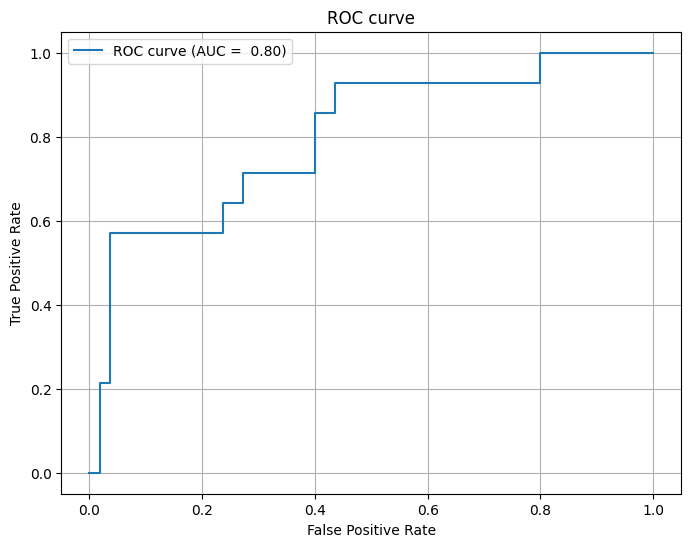

In [13]:
metrics_logistic_regr.plot_roc_curve(false_positive_rate_values, true_positive_rate_values, auc_roc_value)

### **Explicacion**:

Se puede concluir mirando los resultados que un lambda de regularizacion con valores alrededor de 0.01 presenta un buen balance entre precision y recall. Es el punto en el que la regularizacion es fuerte como para evitar el overfitting pero no tan fuerte como para causar underfitting.

## **Regresion Logistica con regularizacion L2 utilizando undersampling imbalance (eliminacion aleatoria de muestras de la clase mayoritaria) para balancear el dataset. Se utiliza cross-validation para entenar el modelo y la metrica f-score para elegir el mejor lambda de regularizacion.**

Average f-scores: {0: 0.7608694448778012, 0.0001: 0.7586051299733176, 0.001: 0.7708300489313928, 0.01: 0.7680304271278523, 0.1: 0.7739877488430947, 1: 0.7652811124032992, 10: 0.526077655459545, 100: 0.3700757270502354}
The best lambda is 0.1 with an average f2-score of 0.7740


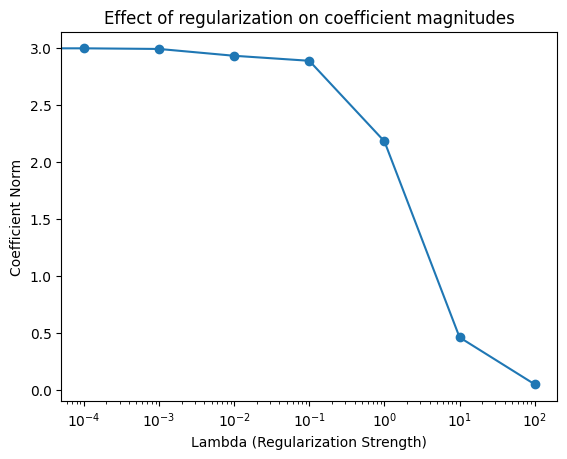

In [4]:
MAX_ITER = 10
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_undersampling = LogisticRegressionUndersampling(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_undersampling.undersampling()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_undersampling.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_undersampling.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_undersampling.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f2 metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_undersampling.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm

for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda_undersampling = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda_undersampling} with an average f2-score of {global_results[best_lambda_undersampling]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

### **Explicacion**

Se puede observar en los resultados que a medida que el valor de lambda incrementa la regularizacion se vuelve mas fuerte, reduciendo asi la magnitud de los coeficientes, lo que limita la expresividad y complejidad del modelo. Los lambdas mas chicos mantienen magnitudes de los coeficientes mas altos y ademas obtienen un mejor f-score. Se puede determinar con los resultados que una minima regularizacion es suficiente para obtener un buen balance entre precision y recall.

## **Entrenamiento en el dev set completo del modelo de regresion logistica con undersampling imbalance**

In [15]:
reg_with_undersampling_best_lambda = LogisticRegressionUndersampling(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_undersampling
)
#print(df)
balanced_df = reg_with_undersampling_best_lambda.undersampling()
print(best_lambda_undersampling)


X_train_full, y_train_full = balanced_df.drop(columns=['target']), balanced_df['target']
reg_with_undersampling_best_lambda.fit(X_train_full, y_train_full)

0.01


## **Analisis del modelo con distintas metricas utilizando el test set**

In [16]:
y_pred_test = reg_with_undersampling_best_lambda.predict(X_test)
y_pred_prob_test = reg_with_undersampling_best_lambda.predict_proba(X_test)
metrics_logistic_regr_undersampling_best_lambda = ClassificationMetrics(y_test, y_pred_test, y_pred_prob_test)

### **1- Confusion Matrix**

In [17]:
metrics_logistic_regr_undersampling_best_lambda.confusion_matrix()

,Predicted Negative,Predicted Positive
Actual Negative,45,10
Actual Positive,6,8


### **2- Accuracy**

In [18]:
accuracy = metrics_logistic_regr_undersampling_best_lambda.accuracy()
print(f'Accuracy for the logistic regression model with undersampling: {accuracy}')

TP = 8, TN = 45, FP = 10, FN = 6
Accuracy for the logistic regression model with undersampling: 0.7681159420289855


### **3- Precision**

In [19]:
precision = metrics_logistic_regr_undersampling_best_lambda.precision()
print(f'Precision for the logistic regression model with undersampling: {precision}')


Precision for the logistic regression model with undersampling: 0.4444444444444444


### **4- F-Score** 

In [20]:
f_score = metrics_logistic_regr_undersampling_best_lambda.f_score()
print(f'F-Score for the logistic regression model with undersampling: {f_score}')

F-Score for the logistic regression model with undersampling: 0.5


### **5- AUC-PR**

In [21]:
recall_values, precision_values, auc_pr_value = metrics_logistic_regr_undersampling_best_lambda.auc_pr()
print(f'Area un the curve PR: {auc_pr_value}')

Area un the curve PR: 0.5066355976620718


### **6- AUC-PR curve**

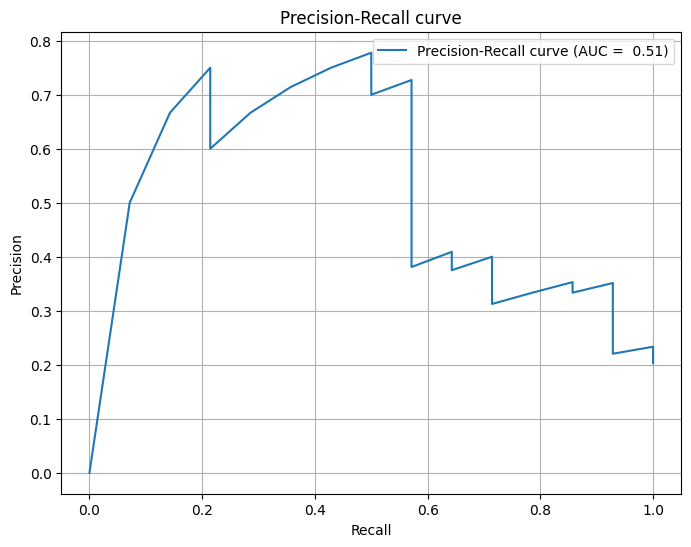

In [22]:
metrics_logistic_regr_undersampling_best_lambda.plot_pr_curve(recall_values, precision_values, auc_pr_value)

### **7- AUC-ROC**

In [23]:
true_positive_rate_values, false_positive_rate_values, auc_roc_value = metrics_logistic_regr_undersampling_best_lambda.auc_roc()
print(f'AUC-ROC fot the logistic regression with undersampling: {auc_roc_value}')

AUC-ROC fot the logistic regression with undersampling: 0.7974025974025973


### **8- ROC curve**

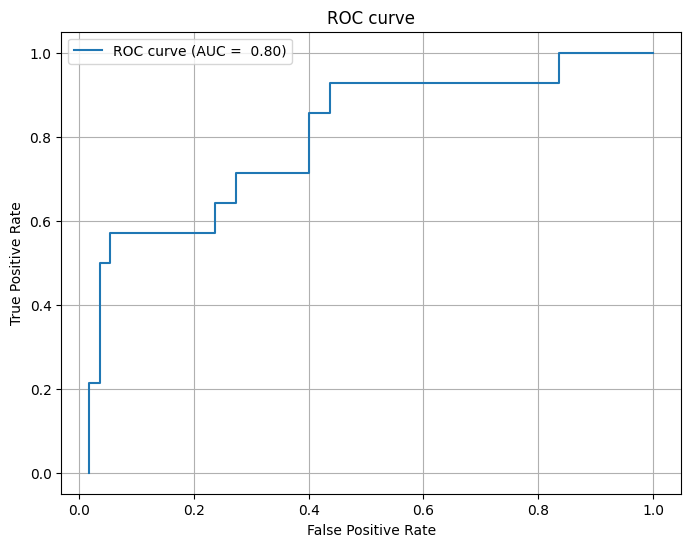

In [24]:
metrics_logistic_regr_undersampling_best_lambda.plot_roc_curve(false_positive_rate_values, true_positive_rate_values, auc_roc_value)

## **Regresion logistica con oversampling por duplicacion (duplicacion aleatoria de muestras de la clase minoritaria) utilizando regularizacion L2. Se entrena el modelo utilizando el metodo de cross-validation y se utiliza la metrica f-score para hallar el mejor lambda de regularizacion**

Average f-scores: {0: 0.7899963370952103, 0.0001: 0.7927497353049049, 0.001: 0.7937059677124055, 0.01: 0.7736241773149606, 0.1: 0.7818055054033597, 1: 0.7935141075313543, 10: 0.7611429710198354, 100: 0.5202863466978899}
The best lambda is 0.001 with an average f-score of 0.7937


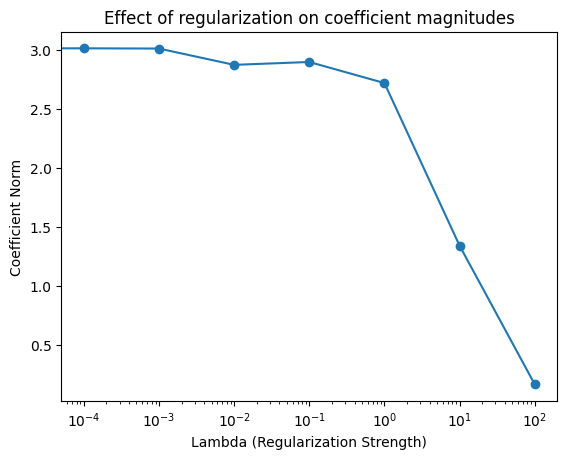

In [5]:
MAX_ITER = 10
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_oversampling = LogisticRegressionOversampling(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_oversampling.oversampling()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_oversampling.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_oversampling.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_oversampling.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_oversampling.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda_oversampling = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda_oversampling} with an average f-score of {global_results[best_lambda_oversampling]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

En este caso hay un equilibrio en el resultado del f-score para la mayoria de las regularizaciones, salvo el caso extremo de lambda=100.

## **Entrenamiento en el dev set completo utilizando el modelo de regresion logistica con oversampling por duplicacion**

In [25]:
reg_with_oversampling_best_lambda = LogisticRegressionOversampling(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_oversampling
)
#print(df)
balanced_df = reg_with_oversampling_best_lambda.oversampling()
print(best_lambda_oversampling)


X_train_full, y_train_full = balanced_df.drop(columns=['target']), balanced_df['target']
reg_with_oversampling_best_lambda.fit(X_train_full, y_train_full)

0


## **Analisis de metricas del modelo en el test set**

In [26]:
y_pred_test = reg_with_oversampling_best_lambda.predict(X_test)
y_pred_prob_test = reg_with_oversampling_best_lambda.predict_proba(X_test)
metrics_logistic_regr_oversampling = ClassificationMetrics(y_test, y_pred_test, y_pred_prob_test)

### **1- Confusion matrix**

In [27]:
metrics_logistic_regr_oversampling.confusion_matrix()

,Predicted Negative,Predicted Positive
Actual Negative,48,7
Actual Positive,6,8


### **2- Accuracy**

In [28]:
accuracy = metrics_logistic_regr_oversampling.accuracy()
print(f'Accuracy for the logistic regression with oversampling model: {accuracy}')

TP = 8, TN = 48, FP = 7, FN = 6
Accuracy for the logistic regression with oversampling model: 0.8115942028985508


### **3- Precision**

In [29]:
precision = metrics_logistic_regr_oversampling.precision()
print(f'Precision for the logistic regression with oversampling: {precision}')

Precision for the logistic regression with oversampling: 0.5333333333333333


### **4- Recall**

In [34]:
recall = metrics_logistic_regr_oversampling.recall()
print(f'Recall for the logistic regression with oversampling model: {recall}')

Recall for the logistic regression with oversampling model: 0.5714285714285714


### **5- F-Score**

In [31]:
f_score = metrics_logistic_regr_oversampling.f_score()
print(f'F-Score for the logistic regression model with oversampling: {f_score}')

F-Score for the logistic regression model with oversampling: 0.5517241379310344


### **6- AUC-PR**

In [32]:
recall_values, precision_values, auc_pr_value = metrics_logistic_regr_oversampling.auc_pr()
print(f'AUC-PR value for the logistic regression model with oversampling: {auc_pr_value}')

AUC-PR value for the logistic regression model with oversampling: 0.5073242965650564


### **7- PR curve**

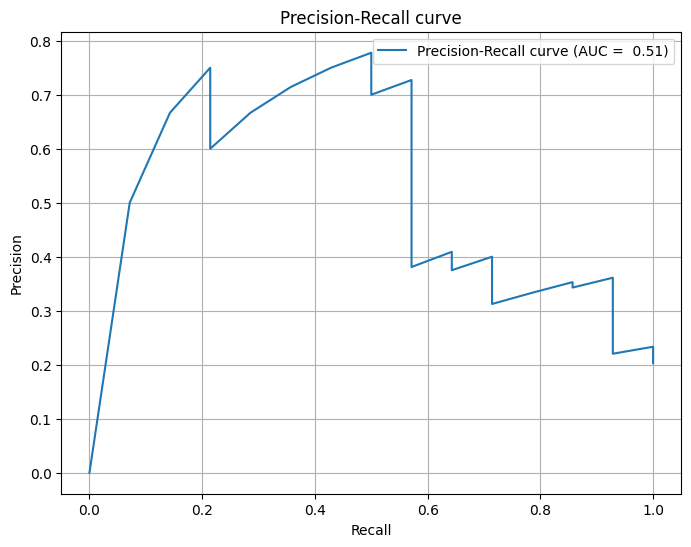

In [33]:
metrics_logistic_regr_oversampling.plot_pr_curve(recall_values, precision_values, auc_pr_value)

### **8- AUC-ROC**

### **9- ROC curve**

## **Logistic Regression with SMOTE oversampling: generates synthetic samples from minority class until both have the same proportion**

Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123569.04iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126765.92iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108646.65iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110173.47iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 107720.27iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 96781.21iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 66356.12iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119584.42iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119376.80iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114345.41iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117054.70iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113932.31iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114236.41iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 106676.43iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105249.65iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122712.23iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113586.74iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111910.78iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 44396.38iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108683.25iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118953.60iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 47412.55iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115622.01iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113023.55iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 80622.48iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 80905.52iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 78238.80iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122218.78iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 90888.10iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 78850.68iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117787.75iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122493.62iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 50501.54iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117025.31iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118714.56iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115092.17iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117077.57iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120356.51iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110667.65iteration/s]


100



Outer Iteration:  10%|█         | 1/10 [00:08<01:14,  8.29s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109879.07iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 89738.85iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 42692.29iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111263.60iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116641.29iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123919.52iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120036.17iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119666.31iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113743.84iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 102345.03iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119799.61iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129294.20iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130039.81iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124604.26iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128813.73iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126601.39iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113827.18iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114780.36iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 99579.87iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125664.50iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125623.10iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125781.32iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115612.45iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127015.44iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123776.90iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126425.85iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126441.09iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123616.39iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128486.21iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111426.17iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119458.40iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122805.65iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124774.77iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115316.84iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108539.81iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116803.70iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108323.97iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110600.53iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110402.57iteration/s]


100



Outer Iteration:  20%|██        | 2/10 [00:16<01:05,  8.25s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103499.17iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117346.17iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128023.44iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121521.19iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115171.18iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116237.22iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 106972.99iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 100565.95iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103264.74iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127196.48iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125042.60iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113540.62iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119285.14iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105689.91iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111907.79iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 131170.38iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 59577.34iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 95251.49iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105157.30iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 90336.08iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116735.43iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117566.54iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130566.06iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 61751.77iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110562.63iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130574.19iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119809.87iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103109.89iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 77196.25iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124227.82iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130330.74iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122172.50iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129007.87iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118282.68iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116492.26iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130132.61iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129669.94iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124205.75iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120786.29iteration/s]


100



Outer Iteration:  30%|███       | 3/10 [00:24<00:56,  8.14s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116060.32iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 106768.76iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112471.95iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110600.53iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 106139.23iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125225.53iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113038.78iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112135.17iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116037.85iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126750.60iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 134260.69iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128313.26iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129750.17iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127762.16iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126212.81iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127816.67iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126167.25iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125259.19iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118309.38iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 85556.14iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122400.68iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108097.83iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115708.13iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112243.20iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105761.86iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112880.59iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 92330.64iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105724.54iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 107681.55iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110318.36iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116888.33iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 104351.50iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116576.45iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 90656.29iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109850.30iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123828.06iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124953.20iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126133.10iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123361.88iteration/s]


100



Outer Iteration:  40%|████      | 4/10 [00:32<00:48,  8.15s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116563.49iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105241.73iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112087.23iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105964.93iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105665.94iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128746.52iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125985.34iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123155.42iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117586.32iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121044.24iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128525.59iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127405.12iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121247.19iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127789.41iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126243.20iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116208.24iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119615.11iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118446.36iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116031.43iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121180.63iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128766.28iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127715.48iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123115.65iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124415.76iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128647.79iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 131190.89iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127902.42iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123660.12iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114670.53iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126988.53iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 133508.53iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125623.10iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 131623.17iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126368.71iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114849.51iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125664.50iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118152.74iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126057.28iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119506.05iteration/s]


100



Outer Iteration:  50%|█████     | 5/10 [00:40<00:40,  8.03s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125604.29iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122361.40iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119816.72iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 107188.96iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113506.82iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128900.83iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127521.33iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120577.95iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118319.39iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120609.16iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118506.60iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118530.04iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124942.03iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115647.51iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124213.11iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118086.21iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 81534.62iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123083.14iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116914.40iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123532.65iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115079.54iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120654.26iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122436.41iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118882.80iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124927.15iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127945.34iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 88186.03iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119768.82iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 100810.08iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 132133.19iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129365.99iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122723.00iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125300.35iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 67211.02iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 80233.84iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127501.95iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120290.93iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129322.11iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125807.73iteration/s]


100



Outer Iteration:  60%|██████    | 6/10 [00:48<00:32,  8.00s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 132354.18iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125042.60iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 78026.30iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 97376.64iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 92292.04iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126186.23iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126258.40iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121821.20iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123079.52iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103999.60iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121655.13iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111717.03iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 100667.32iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108209.39iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126361.10iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128325.04iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123028.98iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108203.80iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121194.64iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126938.56iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 133734.15iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 92174.40iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 85561.37iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126155.86iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109349.11iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 132329.13iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112828.97iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121159.63iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115724.09iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120249.54iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118276.01iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123758.64iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114937.63iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115478.76iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129959.22iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110775.80iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119274.96iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121369.99iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111245.90iteration/s]


100



Outer Iteration:  70%|███████   | 7/10 [00:56<00:23,  7.98s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 133653.18iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 69764.38iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 107131.47iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128817.69iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125758.70iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111520.98iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121299.79iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 44376.19iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115025.89iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124748.80iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130892.02iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127200.34iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122787.67iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114189.76iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122989.30iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123470.83iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124360.42iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118798.62iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126095.18iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 79173.66iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129995.47iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126950.09iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110714.39iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114507.74iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125091.08iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128309.34iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120831.53iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125766.24iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128348.60iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111104.45iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 104936.30iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 106454.42iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 107753.47iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121962.90iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114177.32iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 131846.60iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113227.98iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125955.08iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120270.23iteration/s]


100



Outer Iteration:  80%|████████  | 8/10 [01:04<00:15,  7.90s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128336.82iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 121708.08iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125117.20iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111263.60iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105972.97iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129870.70iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 127200.34iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123032.59iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119666.31iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105381.87iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124915.98iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 129834.51iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126080.02iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119291.92iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 120480.97iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124198.40iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124183.69iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118526.69iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123543.56iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115590.14iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 126391.56iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115555.11iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113497.61iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113002.24iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 119004.23iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116813.46iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 97381.16iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123620.03iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113565.21iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113093.64iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 117523.72iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108818.60iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111148.61iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123209.68iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123554.48iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114595.34iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 97036.46iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 95100.31iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115819.96iteration/s]


100



Outer Iteration:  90%|█████████ | 9/10 [01:12<00:07,  7.97s/iteration]

100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103522.16iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105028.27iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 112731.92iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 90006.52iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118509.95iteration/s]


0



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 128825.60iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124341.99iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122215.22iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109838.79iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 118721.28iteration/s]


0.0001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109899.23iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 122780.48iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124693.17iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114448.37iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123641.89iteration/s]


0.001



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 105594.12iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 108444.40iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 103534.94iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 102500.10iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 104541.36iteration/s]


0.01



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114195.98iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 110661.81iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109951.08iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109804.28iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 114233.30iteration/s]


0.1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 101786.20iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 115275.64iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116595.89iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116982.87iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 116282.34iteration/s]


1



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 130330.74iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 124656.11iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 125803.96iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 111290.17iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 109881.95iteration/s]


10



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 123028.98iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 102173.00iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113221.87iteration/s]


100



Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 104928.43iteration/s]


100



Outer Iteration: 100%|██████████| 10/10 [01:20<00:00,  8.04s/iteration]


100
Average f-scores: {0: 0.7915748655752346, 0.0001: 0.8013920013225884, 0.001: 0.7933001704992343, 0.01: 0.7949784548826755, 0.1: 0.7975607297695501, 1: 0.7956593244174379, 10: 0.7686438835283097, 100: 0.561618024414415}
The best lambda is 0.0001 with an average f2-score of 0.8014


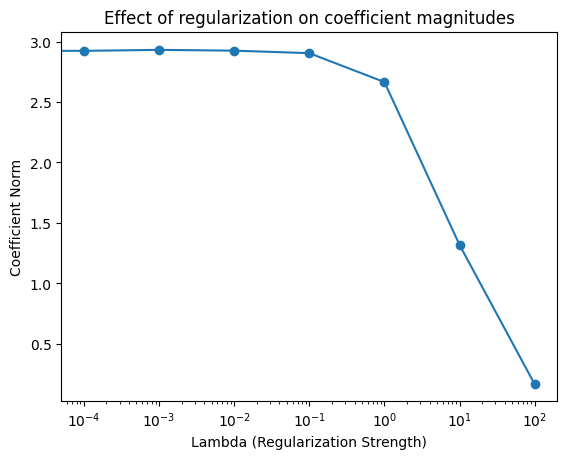

In [6]:
MAX_ITER = 10
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in tqdm(range(MAX_ITER), desc="Outer Iteration", unit="iteration"):
    for lambda_ in tqdm(lambdas, desc="Lambda Values", unit="lambda"):
        reg_with_smote = LogisticRegressionSmote(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_smote.smote()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_smote.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_smote.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_smote.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_smote.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda_smote = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda_smote} with an average f2-score of {global_results[best_lambda_smote]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

## **Entrenamiento en el dev set completo del modelo de regresion logistica con smote**

In [35]:
reg_with_smote_best_lambda = LogisticRegressionSmote(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_smote
)
print(best_lambda_smote)
balanced_df = reg_with_smote_best_lambda.smote()

X_train_full, y_train_full = balanced_df.drop(columns=['target']), balanced_df['target']
reg_with_smote_best_lambda.fit(X_train_full, y_train_full)

0


Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 113252.44iteration/s]


## **Analisis del modelo utilizando metricas en el test set**

In [36]:
y_pred_test = reg_with_smote_best_lambda.predict(X_test)
y_pred_prob_test = reg_with_smote_best_lambda.predict_proba(X_test)
metrics_logistic_regr_smote = ClassificationMetrics(y_test, y_pred_test, y_pred_prob_test)

0


### **1- Confussion matrix**

In [37]:
metrics_logistic_regr_smote.confusion_matrix()

,Predicted Negative,Predicted Positive
Actual Negative,46,9
Actual Positive,6,8


### **2- Accuracy**

In [38]:
accuracy = metrics_logistic_regr_smote.accuracy()
print(f'Accuracy for the test set using the logistic regression model with smote {accuracy}')

TP = 8, TN = 46, FP = 9, FN = 6
0.782608695652174


### **3- Precision**

In [42]:
precision = metrics_logistic_regr_smote.precision()
print(f'Precision for the test set using the logistic regression model with smote {precision}')

Precision for the test set using the logistic regression model with smote 0.47058823529411764


### **4- Recall**

In [43]:
recall = metrics_logistic_regr_smote.recall()
print(f'Recall for the test set using the logistic regression model with smote {recall}')

Recall for the test set using the logistic regression model with smote 0.5714285714285714


### **5- F-Score**

In [44]:
f_score = metrics_logistic_regr_smote.f_score()
print(f'F_Score for the test set using the logistic regression model with smote {f_score}')

F_Score for the test set using the logistic regression model with smote 0.5161290322580646


### **6- AUC-PR value**

In [45]:
recall_values, precision_values, auc_pr_value = metrics_logistic_regr_smote.auc_pr()
print(f'AUC-PR value for the test set using the logistic regression model with smote {auc_pr_value}')

AUC-PR value for the test set using the logistic regression model with smote 0.5137050213750378


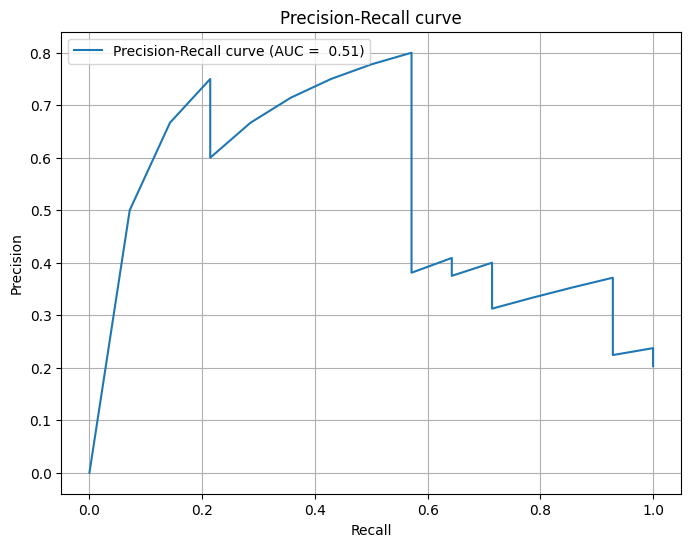

In [46]:
metrics_logistic_regr_smote.plot_pr_curve(recall_values, precision_values, auc_pr_value)

Average f-scores: {0: 0.0, 0.0001: 0.0, 0.001: 0.0, 0.01: 0.0, 0.1: 0.0, 1: 0.0, 10: 0.0, 100: 0.0}
The best lambda is 0 with an average f2-score of 0.0000


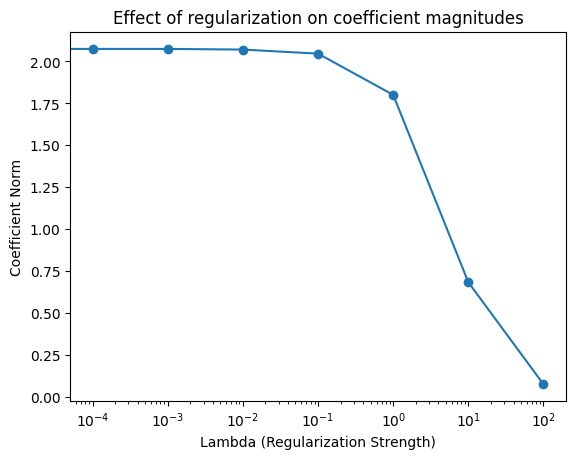

In [7]:
MAX_ITER = 10
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_cost_reweighting = LogisticRegressionCostReWeighting(
            df, threshold=0.7, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        training, validation = cross_val(df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_cost_reweighting.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_cost_reweighting.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_cost_reweighting.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_cost_reweighting.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda_reweighting = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda_reweighting} with an average f2-score of {global_results[best_lambda_reweighting]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

## **Entrenamiento en el dev set completo del modelo de regresion logistica con cost reweighting utilizando el mejor lambda encontrado anteriormente con cross-validation**

In [48]:
reg_with_cost_re_weighting_best_lambda = LogisticRegressionCostReWeighting(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_reweighting
)
print(best_lambda_reweighting)

X_train_full, y_train_full = df.drop(columns=['target']), df['target']
reg_with_cost_re_weighting_best_lambda.fit(X_train_full, y_train_full)

0


## **Analisis de metricas del modelo de regresion logistica con cost reweighting en el test set**

In [57]:
y_pred_test = reg_with_cost_re_weighting_best_lambda.predict(X_test)
y_pred_prob_test = reg_with_cost_re_weighting_best_lambda.predict_proba(X_test)
metrics_logistic_regr_cost_reweighting = ClassificationMetrics(y_test, y_pred_test, y_pred_prob_test)

### **1- Accuracy**

In [58]:
accuracy = metrics_logistic_regr_cost_reweighting.accuracy()
print(f'Accuracy for the test set using the logistic regression model with cost reweighting {accuracy}')

TP = 0, TN = 55, FP = 0, FN = 14
Accuracy for the test set using the logistic regression model with cost reweighting 0.7971014492753623


### **2- Precision**

In [59]:
precision = metrics_logistic_regr_cost_reweighting.precision()
print(f'Precision for the test set using the logistic regression model with cost reweighting {precision}')

Precision for the test set using the logistic regression model with cost reweighting 0


### **3- Recall**

In [60]:
recall = metrics_logistic_regr_cost_reweighting.recall()
print(f'Recall for the test set using the logistic regression model with cost reweighting {recall}')

Recall for the test set using the logistic regression model with cost reweighting 0.0


### **4- F-Score**

In [61]:
f_score = metrics_logistic_regr_cost_reweighting.f_score()
print(f'F-Score for the test set using the logistic regression model with cost reweighting {f_score}')

F-Score for the test set using the logistic regression model with cost reweighting 0


### **5- AUC-PR**

In [62]:
recall_values, precision_values, auc_pr_value = metrics_logistic_regr_cost_reweighting.auc_pr()
print(f'AUC-PR value for the test set using the logistic regression model with cost reweighting {auc_pr_value}')

AUC-PR value for the test set using the logistic regression model with cost reweighting 0.5125742483729394


### **6- PR curve**

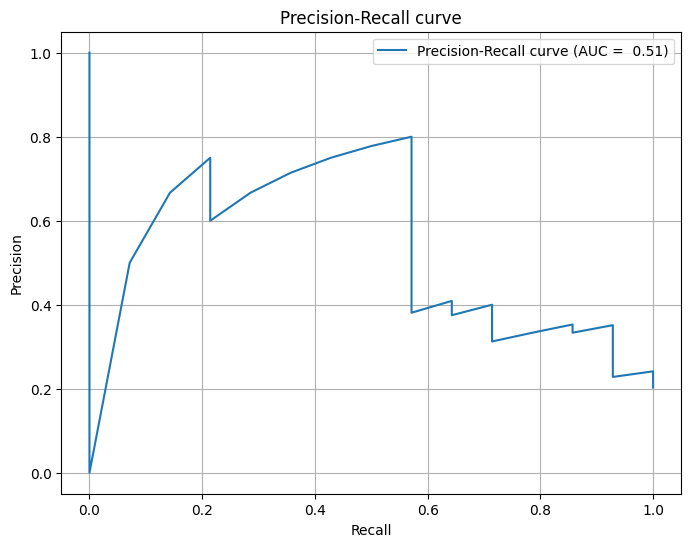

In [56]:
metrics_logistic_regr_cost_reweighting.plot_pr_curve(recall_values, precision_values, auc_pr_value)

Training Model: 100%|██████████| 1000/1000 [00:00<00:00, 93393.54iteration/s]

0.0001


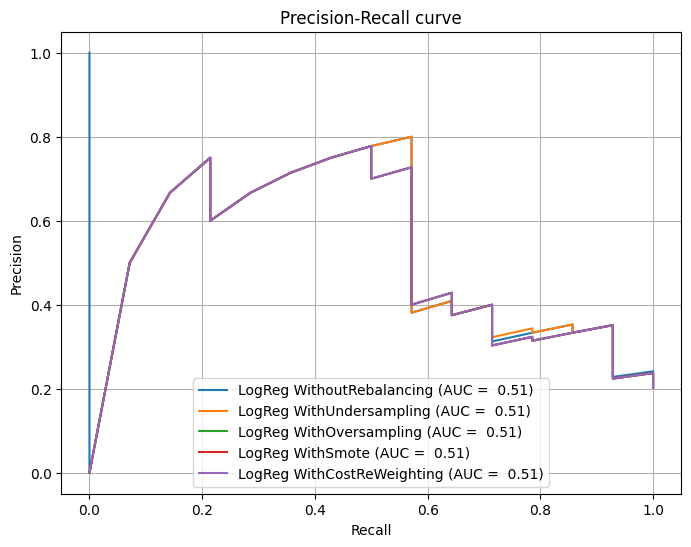

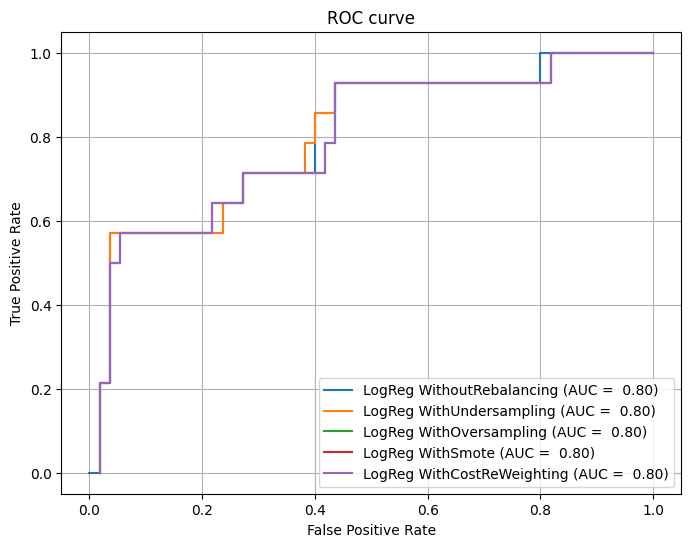

In [8]:
reg_without_balancing_best_lambda = LogisticRegression(
    threshold=0.245, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_without_balancing
)
reg_with_undersampling_best_lambda = LogisticRegressionUndersampling(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_undersampling
)
reg_with_oversampling_best_lambda = LogisticRegressionOversampling(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_oversampling
)
reg_with_smote_best_lambda = LogisticRegressionSmote(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_smote
)
reg_with_cost_re_weighting_best_lambda = LogisticRegressionCostReWeighting(
    df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=best_lambda_reweighting
)

models = [reg_without_balancing_best_lambda, reg_with_undersampling_best_lambda,
          reg_with_oversampling_best_lambda, reg_with_smote_best_lambda,
          reg_with_cost_re_weighting_best_lambda]

model_names = ['LogReg WithoutRebalancing', 'LogReg WithUndersampling',
               'LogReg WithOversampling', 'LogReg WithSmote',
               'LogReg WithCostReWeighting']

precision_values_list = []
recall_values_list = []
auc_pr_values_list = []

false_positive_rate_values_list = []
true_positive_rate_values_list = []
auc_roc_value_list = []

for model, name in zip(models, model_names):
    if name == 'LogReg WithUndersampling':
        df = model.undersampling()

    elif name == 'LogReg WithOversampling':
        df = model.oversampling()

    X_train_full, y_train_full = df.drop(columns=['target']), df['target']
    model.fit(X_train_full, y_train_full)
    predicted_probs = model.predict_proba(X_test)
    predicted_targets = model.predict(X_test)

    metrics = ClassificationMetrics(y_test,
                                    predicted_targets,
                                    predicted_probs)
    
    recall_values, precision_values, auc_pr_value = metrics.auc_pr()
    recall_values_list.append(recall_values)
    precision_values_list.append(precision_values)
    auc_pr_values_list.append(auc_pr_value)

    tpr_values, fpr_values, auc_roc_value = metrics.auc_roc()
    true_positive_rate_values_list.append(tpr_values)
    false_positive_rate_values_list.append(fpr_values)
    auc_roc_value_list.append(auc_roc_value)

metrics.plot_pr_curve(recall_values_list, precision_values_list, auc_pr_values_list, model_names)
metrics.plot_roc_curve(false_positive_rate_values_list, true_positive_rate_values_list, auc_roc_value_list, model_names)